In [1]:
import sys
sys.path.append("../")

import torch

from tdoa.visualization import plot_mics_and_sources
from neural_tdoa.model import TdoaCrnn
from neural_tdoa.utils.load_config import load_config
from datasets.dataset import TdoaDataset
from datasets.visualization import plot_microphone_signals


def load_model():
    model = TdoaCrnn()
    
    weights = torch.load("../tests/fixtures/weights.pth",
                         map_location=torch.device('cpu'))["state_dict"]
    weights = {
        k.replace("model.", ""): v for k, v in weights.items()
    }
    
    model.load_state_dict(weights)
    model.eval()

    return model

def eval_model(model, x):
    with torch.no_grad():
        return model(x)

model = load_model()
config = load_config()
dataset = TdoaDataset(config["test_dataset"])

  0%|                                                                                                | 0/100 [00:00<?, ?it/s]

Prediction 0.9794984459877014, Error: 0.4577767252922058


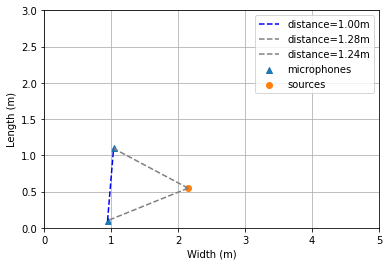

  1%|▉                                                                                       | 1/100 [00:00<00:48,  2.05it/s]

Prediction 0.9886455535888672, Error: 0.011044204235076904


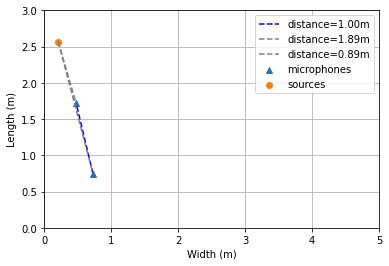

  2%|█▊                                                                                      | 2/100 [00:00<00:44,  2.22it/s]

Prediction 0.9789591431617737, Error: 0.020635604858398438


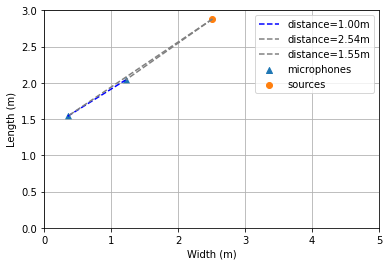

  3%|██▋                                                                                     | 3/100 [00:01<00:42,  2.27it/s]

Prediction 0.985590934753418, Error: 0.203183114528656


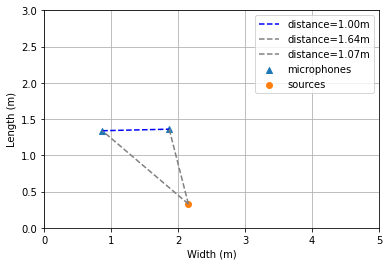

  4%|███▌                                                                                    | 4/100 [00:01<00:40,  2.36it/s]

Prediction 0.9921126365661621, Error: 0.17481976747512817


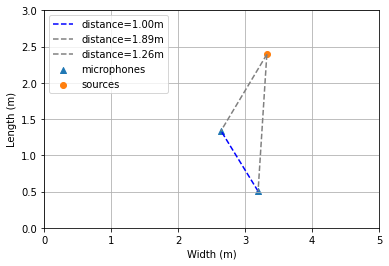

  5%|████▍                                                                                   | 5/100 [00:02<00:40,  2.35it/s]

Prediction 0.9901819825172424, Error: 0.007477879524230957


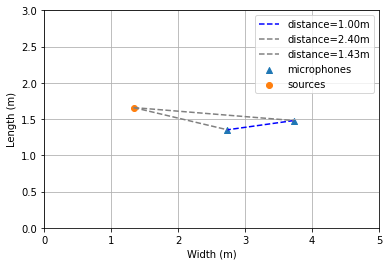

  6%|█████▎                                                                                  | 6/100 [00:02<00:39,  2.36it/s]

Prediction 0.9837137460708618, Error: 0.045684754848480225


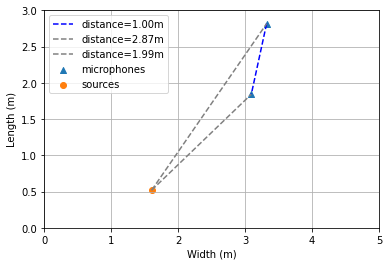

  7%|██████▏                                                                                 | 7/100 [00:02<00:38,  2.40it/s]

Prediction 0.7501636743545532, Error: 0.3703325092792511


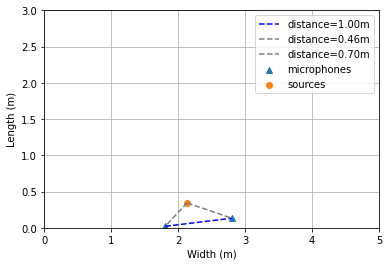

  8%|███████                                                                                 | 8/100 [00:03<00:38,  2.40it/s]

Prediction 0.9811007976531982, Error: 0.5808075070381165


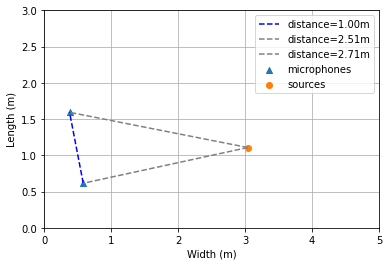

  9%|███████▉                                                                                | 9/100 [00:03<00:40,  2.24it/s]

Prediction 0.9788767695426941, Error: 0.46625983715057373


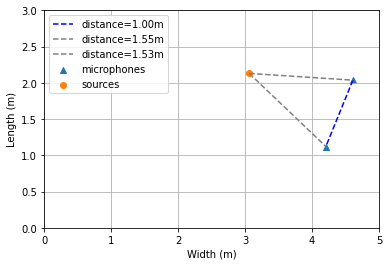

 10%|████████▋                                                                              | 10/100 [00:04<00:39,  2.29it/s]

Prediction 0.9730761051177979, Error: 0.6521252393722534


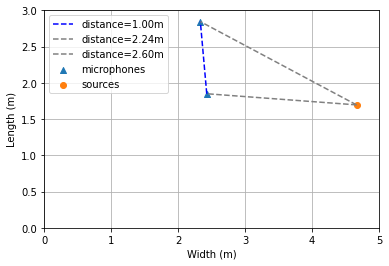

 11%|█████████▌                                                                             | 11/100 [00:04<00:38,  2.31it/s]

Prediction 0.9840075373649597, Error: 0.015865206718444824


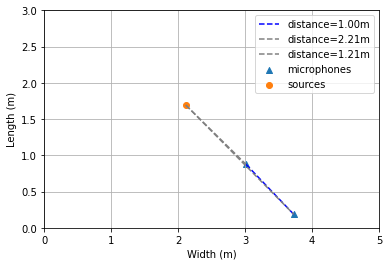

 12%|██████████▍                                                                            | 12/100 [00:05<00:36,  2.41it/s]

Prediction 0.9868052005767822, Error: 0.220805823802948


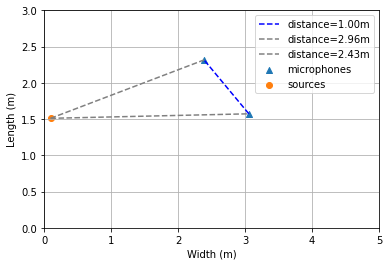

 13%|███████████▎                                                                           | 13/100 [00:05<00:36,  2.41it/s]

Prediction 0.9888038039207458, Error: 0.04064685106277466


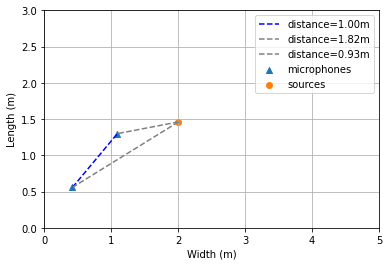

 14%|████████████▏                                                                          | 14/100 [00:05<00:34,  2.46it/s]

Prediction 0.9837660789489746, Error: 0.17727941274642944


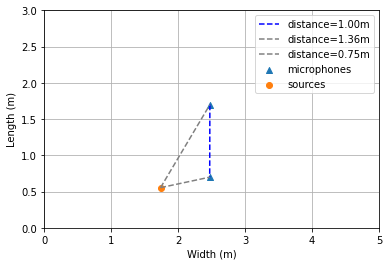

 15%|█████████████                                                                          | 15/100 [00:06<00:34,  2.46it/s]

Prediction 0.9494125843048096, Error: 0.8866328746080399


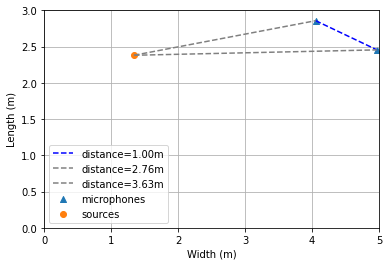

 16%|█████████████▉                                                                         | 16/100 [00:06<00:34,  2.46it/s]

Prediction 0.991866409778595, Error: 0.023164868354797363


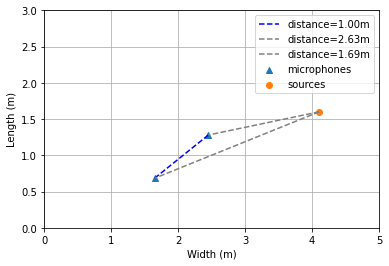

 17%|██████████████▊                                                                        | 17/100 [00:07<00:33,  2.47it/s]

Prediction 0.946542501449585, Error: 0.79106704890728


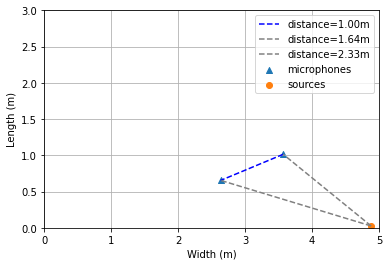

 18%|███████████████▋                                                                       | 18/100 [00:07<00:32,  2.49it/s]

Prediction 0.9885586500167847, Error: 0.010554969310760498


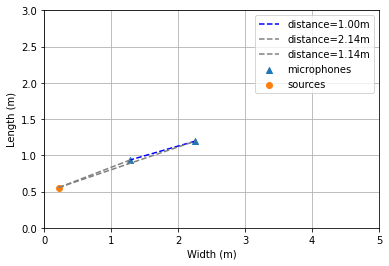

 19%|████████████████▌                                                                      | 19/100 [00:07<00:32,  2.51it/s]

Prediction 0.9760640859603882, Error: 0.6080194711685181


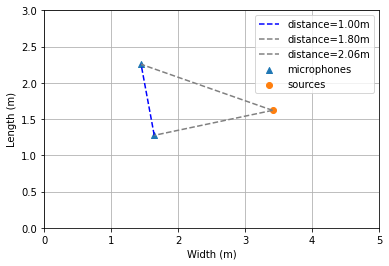

 20%|█████████████████▍                                                                     | 20/100 [00:08<00:31,  2.51it/s]

Prediction 0.9638489484786987, Error: 0.6155310869216919


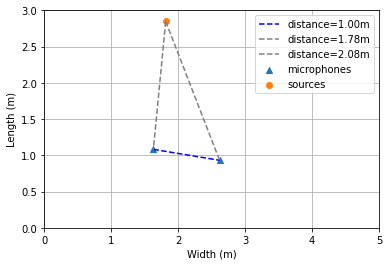

 21%|██████████████████▎                                                                    | 21/100 [00:08<00:31,  2.51it/s]

Prediction 0.968752920627594, Error: 0.6097790002822876


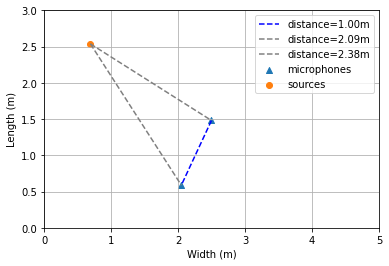

 22%|███████████████████▏                                                                   | 22/100 [00:09<00:31,  2.44it/s]

Prediction 0.985560953617096, Error: 0.5362425446510315


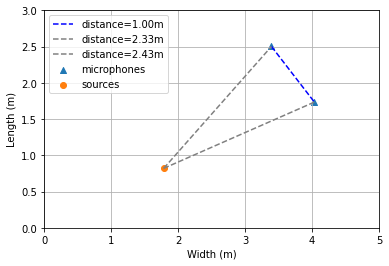

 23%|████████████████████                                                                   | 23/100 [00:09<00:31,  2.44it/s]

Prediction 0.982738196849823, Error: 0.3629060387611389


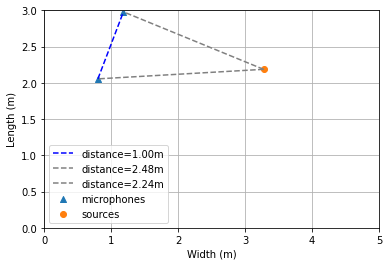

 24%|████████████████████▉                                                                  | 24/100 [00:09<00:31,  2.44it/s]

Prediction 0.9856382012367249, Error: 0.012583494186401367


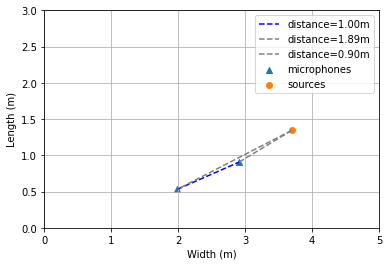

 25%|█████████████████████▊                                                                 | 25/100 [00:10<00:33,  2.24it/s]

Prediction 0.9706548452377319, Error: 0.8484854847192764


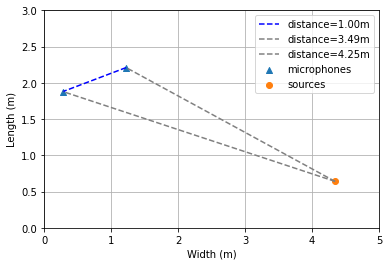

 26%|██████████████████████▌                                                                | 26/100 [00:10<00:32,  2.31it/s]

Prediction 0.9765824675559998, Error: 0.27992111444473267


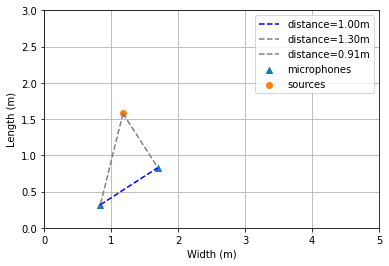

 27%|███████████████████████▍                                                               | 27/100 [00:11<00:30,  2.38it/s]

Prediction 0.0061628990806639194, Error: 0.006108605091867503


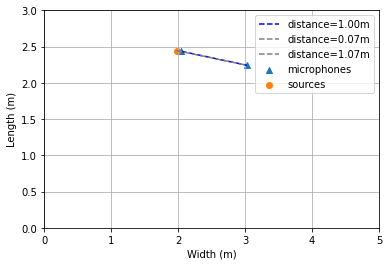

 28%|████████████████████████▎                                                              | 28/100 [00:11<00:30,  2.35it/s]

Prediction 0.9942733645439148, Error: 0.018205702304840088


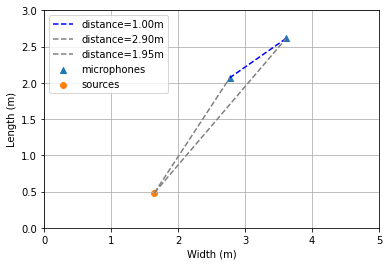

 29%|█████████████████████████▏                                                             | 29/100 [00:12<00:29,  2.40it/s]

Prediction 0.9812209606170654, Error: 0.05223625898361206


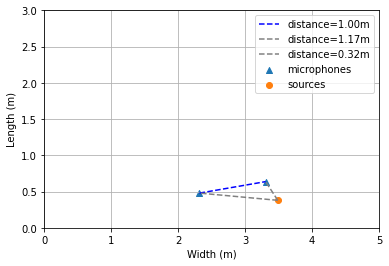

 30%|██████████████████████████                                                             | 30/100 [00:12<00:29,  2.40it/s]

Prediction 0.9855620861053467, Error: 0.06922483444213867


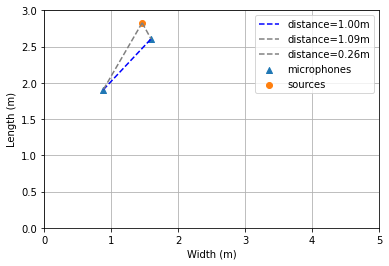

 31%|██████████████████████████▉                                                            | 31/100 [00:12<00:28,  2.45it/s]

Prediction 0.9727905988693237, Error: 0.38777583837509155


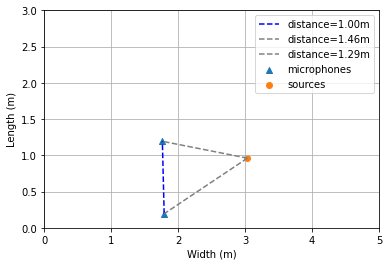

 32%|███████████████████████████▊                                                           | 32/100 [00:13<00:28,  2.35it/s]

Prediction 0.9873450398445129, Error: 0.18431532382965088


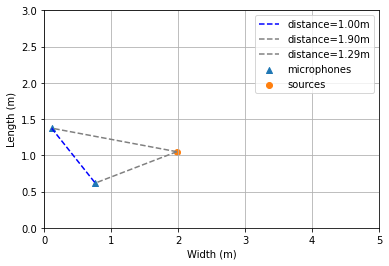

 33%|████████████████████████████▋                                                          | 33/100 [00:13<00:30,  2.22it/s]

Prediction 0.6397557854652405, Error: 0.5387939065694809


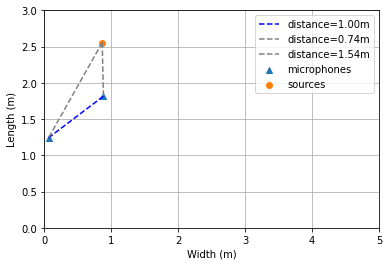

 34%|█████████████████████████████▌                                                         | 34/100 [00:14<00:29,  2.21it/s]

Prediction 0.891678512096405, Error: 0.8644293490797281


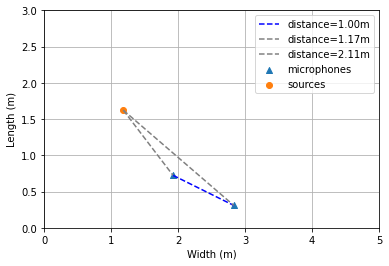

 35%|██████████████████████████████▍                                                        | 35/100 [00:14<00:29,  2.18it/s]

Prediction 0.6352129578590393, Error: 0.5582153052091599


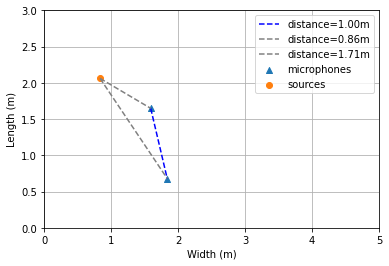

 36%|███████████████████████████████▎                                                       | 36/100 [00:15<00:29,  2.17it/s]

Prediction 0.9819028377532959, Error: 0.16000211238861084


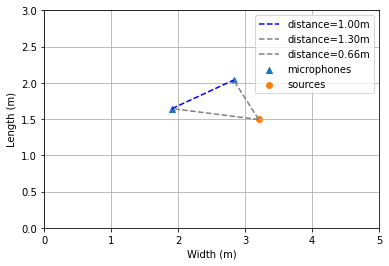

 37%|████████████████████████████████▏                                                      | 37/100 [00:15<00:29,  2.17it/s]

Prediction 0.9848586916923523, Error: 0.03969389200210571


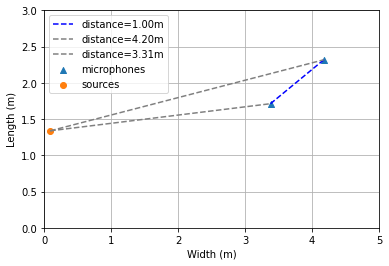

 38%|█████████████████████████████████                                                      | 38/100 [00:16<00:28,  2.16it/s]

Prediction 0.9707332849502563, Error: 0.5867544412612915


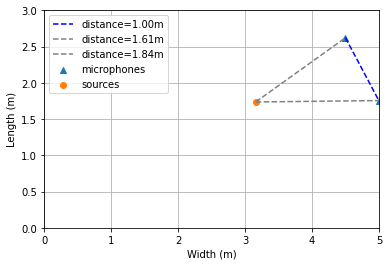

 39%|█████████████████████████████████▉                                                     | 39/100 [00:16<00:28,  2.16it/s]

Prediction 0.9250864386558533, Error: 0.9248434120527236


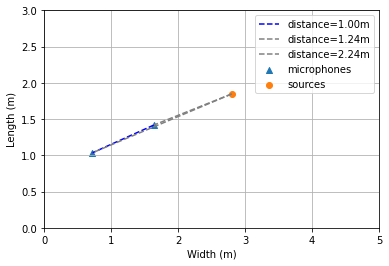

 40%|██████████████████████████████████▊                                                    | 40/100 [00:17<00:27,  2.19it/s]

Prediction 0.9622296094894409, Error: 0.5664249956607819


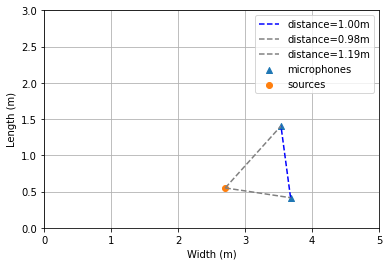

 41%|███████████████████████████████████▋                                                   | 41/100 [00:17<00:29,  1.98it/s]

Prediction 0.9141470193862915, Error: 0.85080236941576


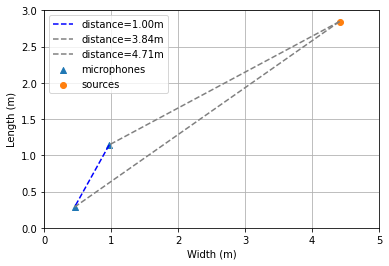

 42%|████████████████████████████████████▌                                                  | 42/100 [00:18<00:29,  1.96it/s]

Prediction 0.9798769354820251, Error: 0.2453833818435669


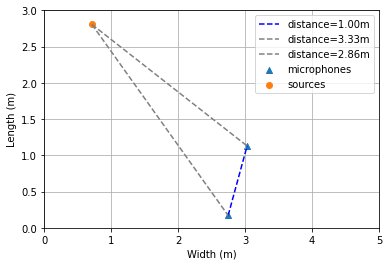

 43%|█████████████████████████████████████▍                                                 | 43/100 [00:18<00:27,  2.05it/s]

Prediction 0.8650563359260559, Error: 0.6550570279359818


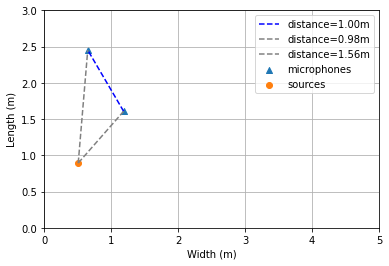

 44%|██████████████████████████████████████▎                                                | 44/100 [00:19<00:27,  2.06it/s]

Prediction 0.9871082901954651, Error: 0.0012258291244506836


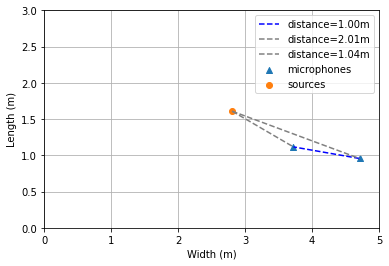

 45%|███████████████████████████████████████▏                                               | 45/100 [00:19<00:26,  2.05it/s]

Prediction 0.008908849209547043, Error: 0.12047276273369789


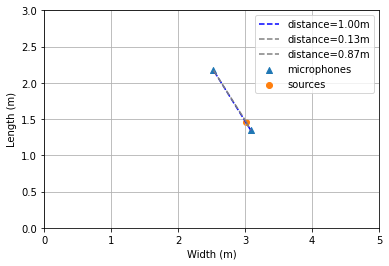

 46%|████████████████████████████████████████                                               | 46/100 [00:20<00:26,  2.07it/s]

Prediction 0.6599100232124329, Error: 0.5600496977567673


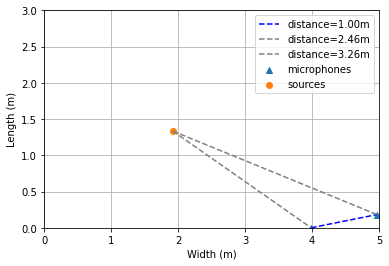

 47%|████████████████████████████████████████▉                                              | 47/100 [00:20<00:25,  2.05it/s]

Prediction 0.985747754573822, Error: 0.023203253746032715


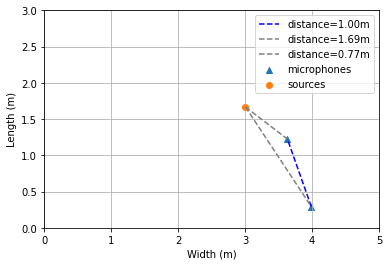

 48%|█████████████████████████████████████████▊                                             | 48/100 [00:21<00:24,  2.16it/s]

Prediction 0.9580481052398682, Error: 0.7818217426538467


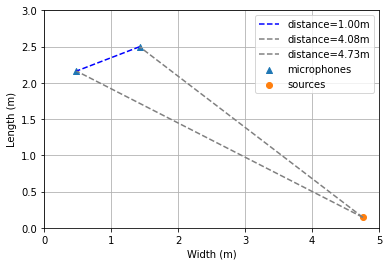

 49%|██████████████████████████████████████████▋                                            | 49/100 [00:21<00:23,  2.19it/s]

Prediction 0.9525386691093445, Error: 0.6947356462478638


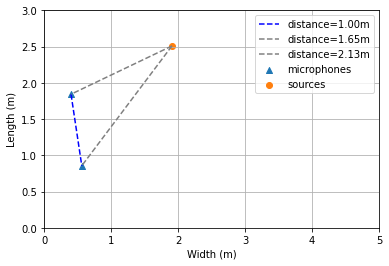

 50%|███████████████████████████████████████████▌                                           | 50/100 [00:21<00:22,  2.20it/s]

Prediction 0.9445818066596985, Error: 0.8384823054075241


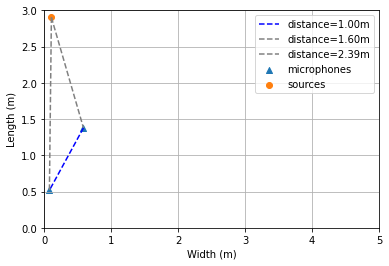

 51%|████████████████████████████████████████████▎                                          | 51/100 [00:22<00:21,  2.24it/s]

Prediction 0.9609202742576599, Error: 0.8963872343301773


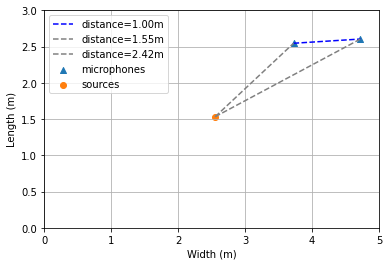

 52%|█████████████████████████████████████████████▏                                         | 52/100 [00:22<00:20,  2.32it/s]

Prediction 0.9466657638549805, Error: 0.7214658111333847


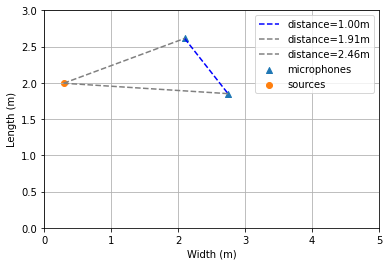

 53%|██████████████████████████████████████████████                                         | 53/100 [00:23<00:20,  2.27it/s]

Prediction 0.9692001938819885, Error: 0.38422441482543945


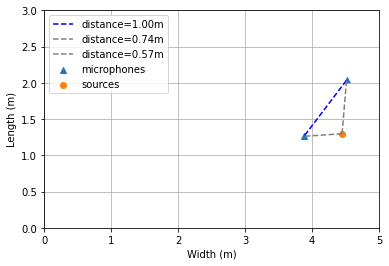

 54%|██████████████████████████████████████████████▉                                        | 54/100 [00:23<00:20,  2.21it/s]

Prediction 0.5129581093788147, Error: 0.5101459126453847


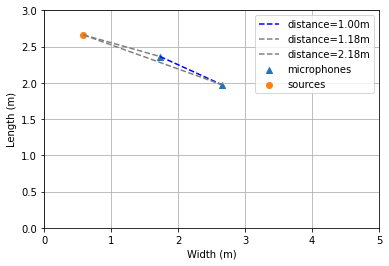

 55%|███████████████████████████████████████████████▊                                       | 55/100 [00:24<00:20,  2.15it/s]

Prediction 0.9783358573913574, Error: 0.19385236501693726


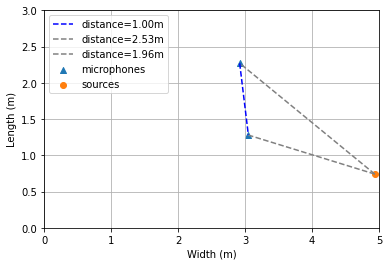

 56%|████████████████████████████████████████████████▋                                      | 56/100 [00:24<00:20,  2.11it/s]

Prediction 0.9859455227851868, Error: 0.27495771646499634


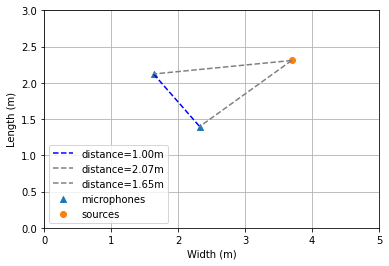

 57%|█████████████████████████████████████████████████▌                                     | 57/100 [00:25<00:23,  1.86it/s]

Prediction 0.8662494421005249, Error: 0.8647703683236614


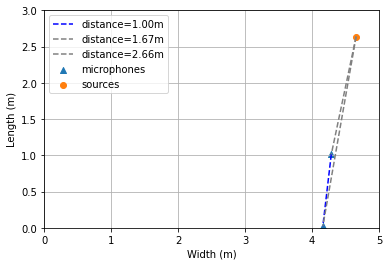

 58%|██████████████████████████████████████████████████▍                                    | 58/100 [00:26<00:26,  1.61it/s]

Prediction 0.9825483560562134, Error: 0.2714148759841919


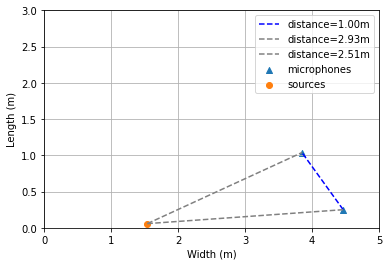

 59%|███████████████████████████████████████████████████▎                                   | 59/100 [00:26<00:24,  1.70it/s]

Prediction 0.16864609718322754, Error: 0.1429655160754919


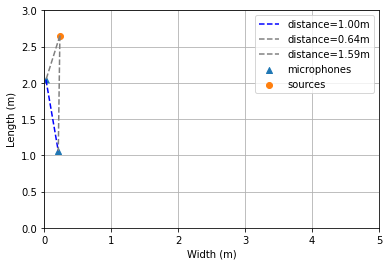

 60%|████████████████████████████████████████████████████▏                                  | 60/100 [00:27<00:22,  1.81it/s]

Prediction 0.9681202173233032, Error: 0.04413110017776489


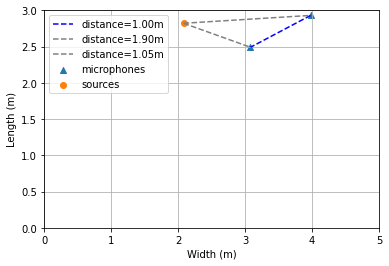

 61%|█████████████████████████████████████████████████████                                  | 61/100 [00:27<00:20,  1.87it/s]

Prediction 0.9755434989929199, Error: 0.0003565549850463867


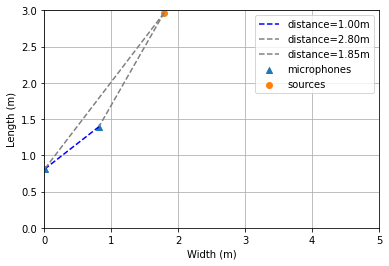

 62%|█████████████████████████████████████████████████████▉                                 | 62/100 [00:28<00:19,  1.94it/s]

Prediction 0.9724810719490051, Error: 0.6028997600078583


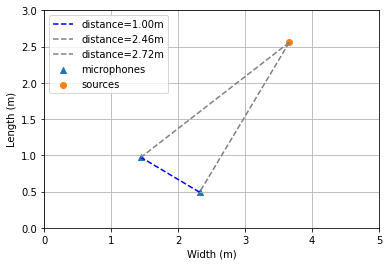

 63%|██████████████████████████████████████████████████████▊                                | 63/100 [00:28<00:18,  1.97it/s]

Prediction 0.9056404829025269, Error: 0.8269497081637383


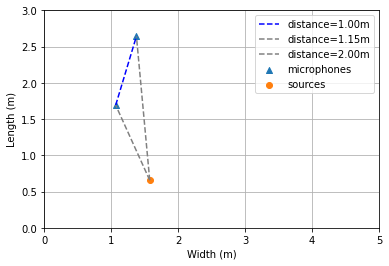

 64%|███████████████████████████████████████████████████████▋                               | 64/100 [00:29<00:17,  2.05it/s]

Prediction 0.9221598505973816, Error: 0.633459061384201


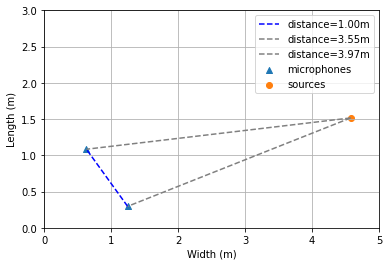

 65%|████████████████████████████████████████████████████████▌                              | 65/100 [00:29<00:16,  2.07it/s]

Prediction 0.9860251545906067, Error: 0.6444390416145325


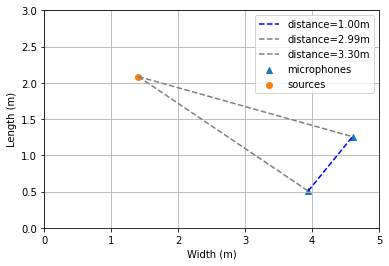

 66%|█████████████████████████████████████████████████████████▍                             | 66/100 [00:30<00:16,  2.11it/s]

Prediction 0.9861895442008972, Error: 0.2360079288482666


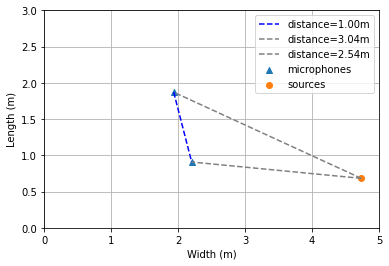

 67%|██████████████████████████████████████████████████████████▎                            | 67/100 [00:30<00:14,  2.20it/s]

Prediction 0.48157864809036255, Error: 0.4731956925243139


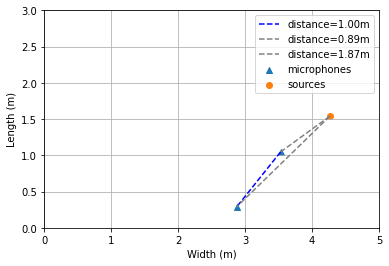

 68%|███████████████████████████████████████████████████████████▏                           | 68/100 [00:30<00:14,  2.24it/s]

Prediction 0.9751945734024048, Error: 0.6436009705066681


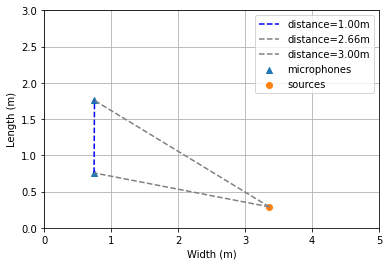

 69%|████████████████████████████████████████████████████████████                           | 69/100 [00:31<00:13,  2.27it/s]

Prediction 0.9890604019165039, Error: 0.16085529327392578


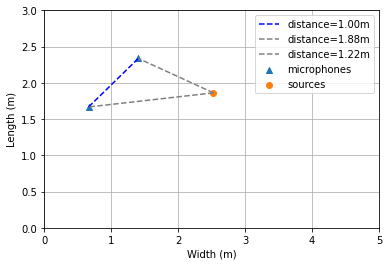

 70%|████████████████████████████████████████████████████████████▉                          | 70/100 [00:31<00:12,  2.31it/s]

Prediction 0.9462600946426392, Error: 0.9260404463857412


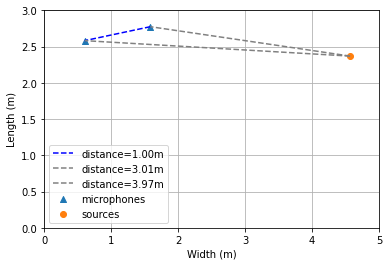

 71%|█████████████████████████████████████████████████████████████▊                         | 71/100 [00:32<00:12,  2.33it/s]

Prediction 0.535203754901886, Error: 0.3421415090560913


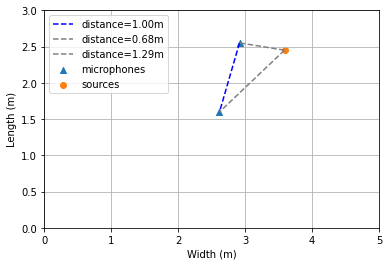

 72%|██████████████████████████████████████████████████████████████▋                        | 72/100 [00:32<00:12,  2.30it/s]

Prediction 0.9912611842155457, Error: 0.01614445447921753


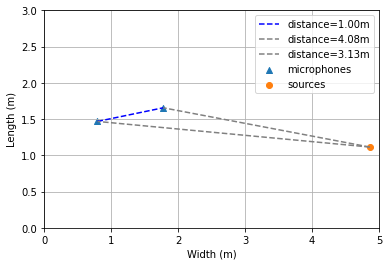

 73%|███████████████████████████████████████████████████████████████▌                       | 73/100 [00:33<00:12,  2.20it/s]

Prediction 0.9621833562850952, Error: 0.9296057522296906


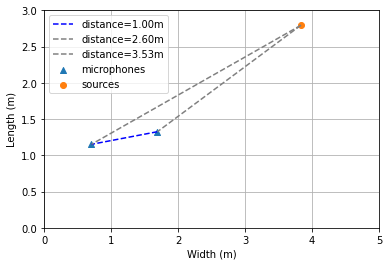

 74%|████████████████████████████████████████████████████████████████▍                      | 74/100 [00:33<00:11,  2.25it/s]

Prediction 0.9793494343757629, Error: 0.017341017723083496


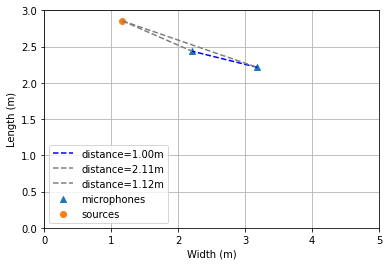

 75%|█████████████████████████████████████████████████████████████████▎                     | 75/100 [00:33<00:10,  2.31it/s]

Prediction 0.966064453125, Error: 0.9062305688858032


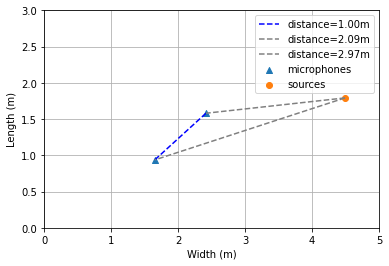

 76%|██████████████████████████████████████████████████████████████████                     | 76/100 [00:34<00:10,  2.37it/s]

Prediction 0.007277142256498337, Error: 0.06005546823143959


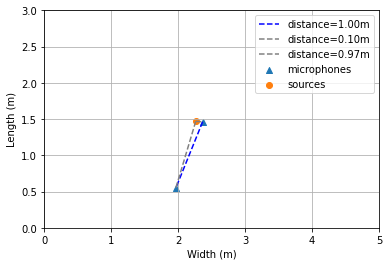

 77%|██████████████████████████████████████████████████████████████████▉                    | 77/100 [00:34<00:09,  2.34it/s]

Prediction 0.9905394315719604, Error: 0.1603650450706482


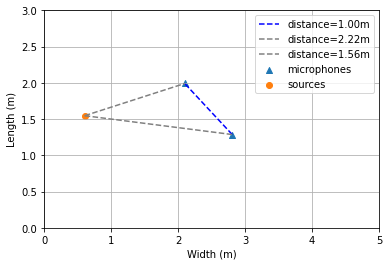

 78%|███████████████████████████████████████████████████████████████████▊                   | 78/100 [00:35<00:09,  2.32it/s]

Prediction 0.7015841007232666, Error: 0.6757002379745245


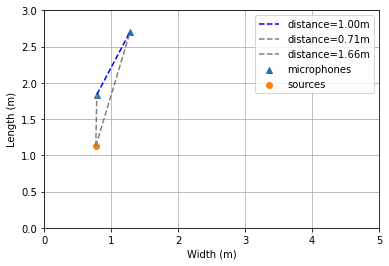

 79%|████████████████████████████████████████████████████████████████████▋                  | 79/100 [00:35<00:09,  2.28it/s]

Prediction 0.9834563136100769, Error: 0.15511149168014526


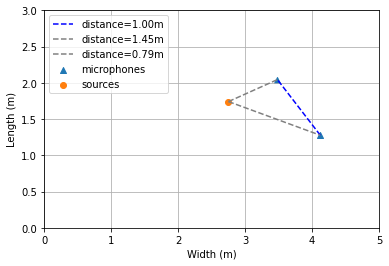

 80%|█████████████████████████████████████████████████████████████████████▌                 | 80/100 [00:36<00:09,  2.20it/s]

Prediction 0.9810164570808411, Error: 0.23203909397125244


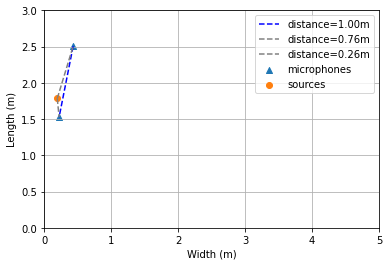

 81%|██████████████████████████████████████████████████████████████████████▍                | 81/100 [00:36<00:09,  1.94it/s]

Prediction 0.9401990175247192, Error: 0.7724711000919342


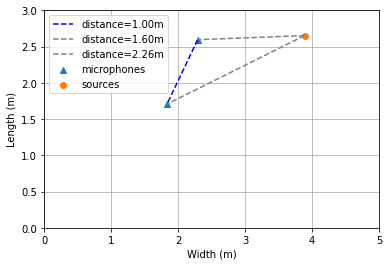

 82%|███████████████████████████████████████████████████████████████████████▎               | 82/100 [00:37<00:09,  1.99it/s]

Prediction 0.9760527014732361, Error: 0.44431746006011963


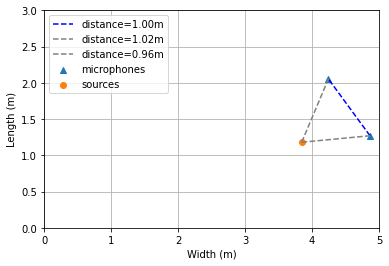

 83%|████████████████████████████████████████████████████████████████████████▏              | 83/100 [00:37<00:08,  2.04it/s]

Prediction 0.981447696685791, Error: 0.5284759104251862


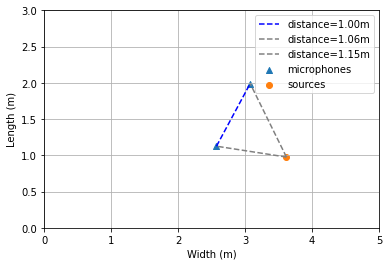

 84%|█████████████████████████████████████████████████████████████████████████              | 84/100 [00:38<00:07,  2.11it/s]

Prediction 0.8084198236465454, Error: 0.6771698296070099


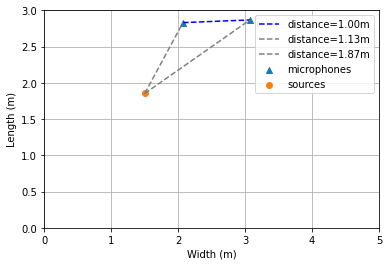

 85%|█████████████████████████████████████████████████████████████████████████▉             | 85/100 [00:38<00:07,  2.14it/s]

Prediction 0.9423737525939941, Error: 0.7198525965213776


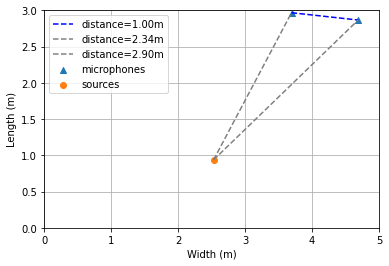

 86%|██████████████████████████████████████████████████████████████████████████▊            | 86/100 [00:39<00:06,  2.11it/s]

Prediction 0.9849321246147156, Error: 0.18279117345809937


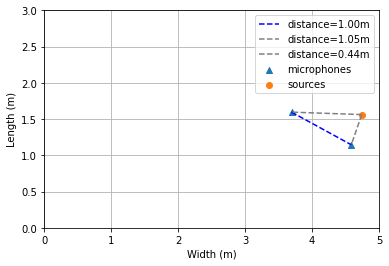

 87%|███████████████████████████████████████████████████████████████████████████▋           | 87/100 [00:39<00:06,  2.06it/s]

Prediction 0.9914085268974304, Error: 0.25063878297805786


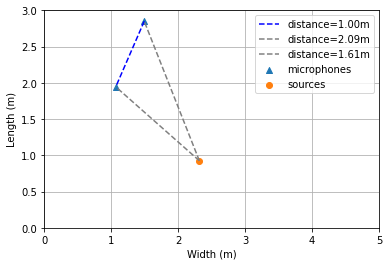

 88%|████████████████████████████████████████████████████████████████████████████▌          | 88/100 [00:40<00:08,  1.49it/s]

Prediction 0.9751018285751343, Error: 0.5864780247211456


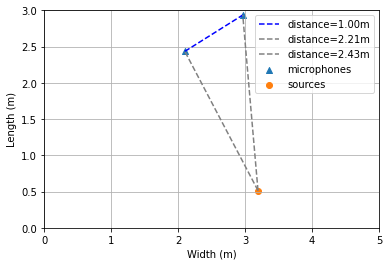

 89%|█████████████████████████████████████████████████████████████████████████████▍         | 89/100 [00:41<00:07,  1.38it/s]

Prediction 0.9856482744216919, Error: 0.010294854640960693


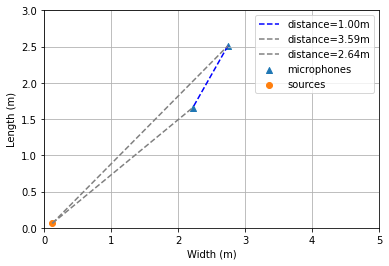

 90%|██████████████████████████████████████████████████████████████████████████████▎        | 90/100 [00:42<00:06,  1.45it/s]

Prediction 0.9719164371490479, Error: 0.8235496133565903


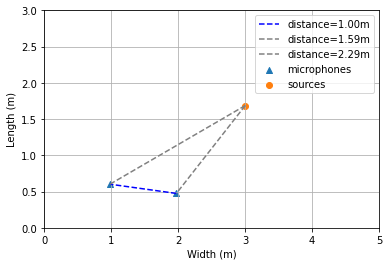

 91%|███████████████████████████████████████████████████████████████████████████████▏       | 91/100 [00:42<00:05,  1.55it/s]

Prediction 0.9867410063743591, Error: 0.0165252685546875


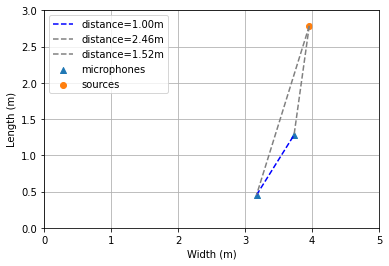

 92%|████████████████████████████████████████████████████████████████████████████████       | 92/100 [00:43<00:04,  1.66it/s]

Prediction 0.9782199859619141, Error: 0.27148962020874023


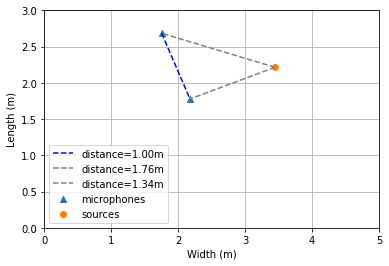

 93%|████████████████████████████████████████████████████████████████████████████████▉      | 93/100 [00:43<00:04,  1.74it/s]

Prediction 0.9829249382019043, Error: 0.3080112338066101


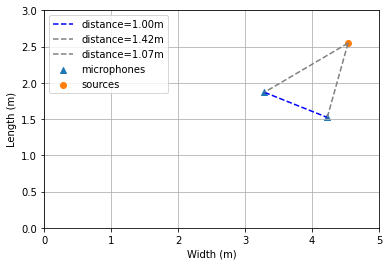

 94%|█████████████████████████████████████████████████████████████████████████████████▊     | 94/100 [00:44<00:03,  1.80it/s]

Prediction 0.947715163230896, Error: 0.804909348487854


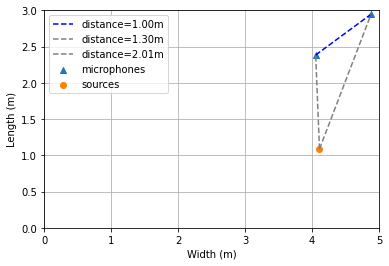

 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 95/100 [00:44<00:02,  1.83it/s]

Prediction 0.9815725088119507, Error: 0.44189709424972534


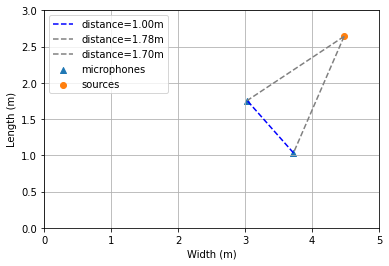

 96%|███████████████████████████████████████████████████████████████████████████████████▌   | 96/100 [00:45<00:02,  1.92it/s]

Prediction 0.9363749027252197, Error: 0.906595703214407


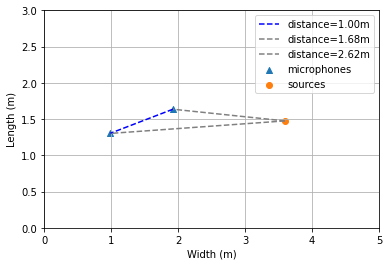

 97%|████████████████████████████████████████████████████████████████████████████████████▍  | 97/100 [00:45<00:01,  1.92it/s]

Prediction 0.9541988372802734, Error: 0.7176003307104111


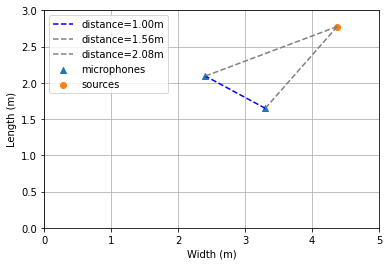

 98%|█████████████████████████████████████████████████████████████████████████████████████▎ | 98/100 [00:46<00:01,  1.96it/s]

Prediction 0.9881624579429626, Error: 0.36349987983703613


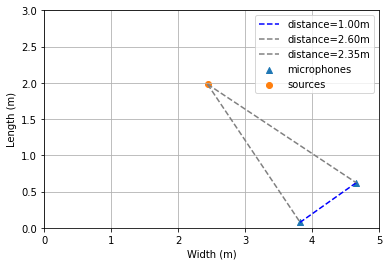

 99%|██████████████████████████████████████████████████████████████████████████████████████▏| 99/100 [00:46<00:00,  1.97it/s]

Prediction 0.06570221483707428, Error: 0.04628502205014229


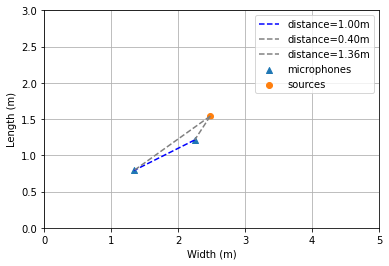

100%|██████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:47<00:00,  2.12it/s]
c:\users\ericg\appdata\local\programs\python\python39\lib\site-packages\numpy\ma\core.py:2825: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  _data = np.array(data, dtype=dtype, copy=copy,
c:\users\ericg\appdata\local\programs\python\python39\lib\site-packages\numpy\ma\core.py:2825: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated.

Error mean: 0.4057759768731921 Error std: 0.305699418467802


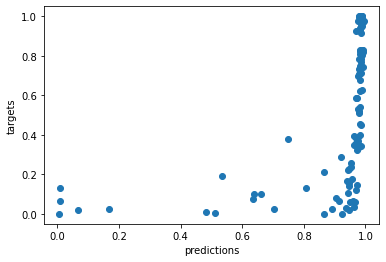

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm, trange


def error(y_gt, y_pred):
    return np.sqrt((y_gt - y_pred)**2)

    
def eval_dataset(model, dataset, sort=True, plot_results=True):

    output_dicts = []
    
    for sample in tqdm(dataset):
        x, y = sample
        prediction = float(eval_model(model, x.unsqueeze(0)).numpy())
        gt = float(y["target"].numpy())
        error_val = error(gt, prediction)
        #print(f"ground_truth: {gt} prediction: {prediction}, error: {error_val}")

        y["prediction"] = prediction
        y["error"] = error_val
        y["signals"] = x
        output_dicts.append(y)
        
        if plot_results:
            plot_sample_results(y)
    
    if sort:       
        output_dicts.sort(key=lambda x: x["error"], reverse=True)
        
    print_dataset_stats(output_dicts)    
    
    return output_dicts

def plot_sample_results(d):
    delay_in_ms = d['mic_delays'][1]*1000
    print(f"Prediction {d['prediction']}, Error: {d['error']}")
    plot_mics_and_sources(d["room_dims"], d["mic_coordinates"], [d["source_coordinates"]])
    
    plt.show()

    #plot_microphone_signals(d["signals"], d, share_axis=False)
    
    plt.show()
    
    
def print_dataset_stats(output_dicts):
    errors = [d["error"] for d in output_dicts]
    avg_error = np.mean(errors)
    std_error = np.std(errors)
    print(f"Error mean: {avg_error} Error std: {std_error}")
    

#     room_dims = eval(sample[0]["room_dims"])
#     mics = eval(sample[0]["mic_coordinates"])
#     sources = [eval(sample[0]["source_coordinates"])]
#     plot_mics_and_sources(room_dims, mics, sources)
#     plt.show()

def scatter_prediction_vs_gt(output_dicts):
    predictions =  [d["prediction"] for d in output_dicts]
    targets =  [d["target"] for d in output_dicts]
    
    plt.scatter(predictions, targets)
    plt.xlabel("predictions")
    plt.ylabel("targets")


output_dicts = eval_dataset(model, dataset, sort=True)

scatter_prediction_vs_gt(output_dicts)


In [3]:
output_dicts[0]

{'Unnamed: 0': 73,
 'room_dims': tensor([5., 3., 3.]),
 'source_coordinates': tensor([3.8343, 2.7948, 1.0000]),
 'mic_coordinates': tensor([[1.6907, 1.3256, 1.0000],
         [0.7060, 1.1518, 1.0000]]),
 'mic_delays': tensor([0.0013, 0.0004]),
 'mic_gains': tensor([0.5000, 1.0000]),
 'mic_sampling_rates': tensor([16000., 16000.]),
 'n_microphone_seconds': 1,
 'tdoa': -0.0027254950174731,
 'normalized_tdoa': 0.0325776045033563,
 'sr': 16000,
 'source_gain': 0.2810356951543693,
 'trim_beginning': False,
 'anechoic': False,
 'signals_dir': 'test_dataset\\samples\\73',
 'target': tensor([0.0326]),
 'prediction': 0.9621833562850952,
 'error': 0.9296057522296906,
 'signals': tensor([[ 0.0000,  0.0000,  0.0000,  ..., -0.0473,  0.0960, -0.1520],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0238,  0.2475, -0.0789]])}